In [1]:
# !pip install shap

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:  
1) всего тестового набора данных (summary_plot - дать интерпретацию)  
2) для топ 10%  
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

import shap
shap.initjs()

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

In [3]:
DATASET = './diabetes_data_upload.csv'

In [4]:
df = pd.read_csv(DATASET)
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [6]:
for col in df.columns:
    print('=' * 50)    
    print(col, ':', df[col].unique())
    if df[col].nunique() == 2:
        print(df[col].value_counts(normalize=True))

Age : [40 58 41 45 60 55 57 66 67 70 44 38 35 61 54 43 62 39 48 32 42 52 53 37
 49 63 30 50 46 36 51 59 65 25 47 28 68 56 31 85 90 72 69 79 34 16 33 64
 27 29 26]
Gender : ['Male' 'Female']
Male      0.630769
Female    0.369231
Name: Gender, dtype: float64
Polyuria : ['No' 'Yes']
No     0.503846
Yes    0.496154
Name: Polyuria, dtype: float64
Polydipsia : ['Yes' 'No']
No     0.551923
Yes    0.448077
Name: Polydipsia, dtype: float64
sudden weight loss : ['No' 'Yes']
No     0.582692
Yes    0.417308
Name: sudden weight loss, dtype: float64
weakness : ['Yes' 'No']
Yes    0.586538
No     0.413462
Name: weakness, dtype: float64
Polyphagia : ['No' 'Yes']
No     0.544231
Yes    0.455769
Name: Polyphagia, dtype: float64
Genital thrush : ['No' 'Yes']
No     0.776923
Yes    0.223077
Name: Genital thrush, dtype: float64
visual blurring : ['No' 'Yes']
No     0.551923
Yes    0.448077
Name: visual blurring, dtype: float64
Itching : ['Yes' 'No']
No     0.513462
Yes    0.486538
Name: Itching, dtype: flo

In [7]:
df['Gender'] = np.where(df['Gender'] == 'Male', 1, 0)
df['class'] = np.where(df['class'] == 'Positive', 1, 0)

In [8]:
for col in df.select_dtypes(include='object'):
    df[col] = np.where(df[col] == 'Yes', 1, 0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis=1), df['class'], 
                                                    test_size=0.3, random_state=42)

In [10]:
model = XGBClassifier(random_state=42)

In [11]:
model.fit(X_train, y_train)

[23:28:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
y_pred = model.predict(X_test)

In [13]:
f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

(0.99009900990099, 0.9901960784313726)

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

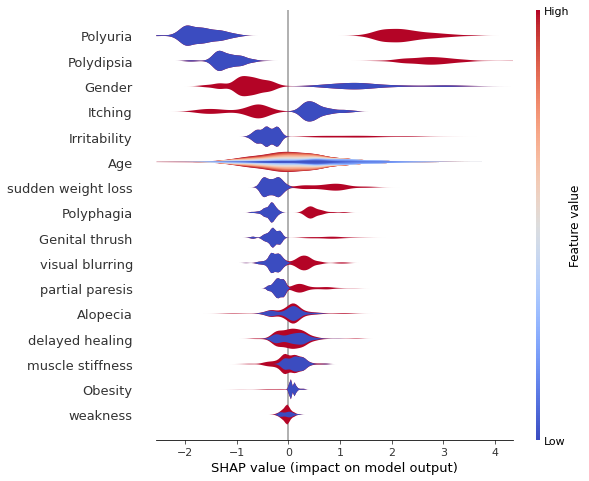

In [15]:
shap.summary_plot(shap_values, X_train, plot_type='layered_violin')

Выводы получаются достаточно интересные:

Ранними признаками диабета по мнению модели является:

- Частое мочеиспускание
- Постоянная жажда
- С большей вероятностью встречается у женщин, нежели у мужчин
- Чесотка нехарактерна
- Может отмечаться раздражительность
- Возраст особого значения не имеет
- Может наблюдаться потеря веса

Выведем 10 наиболее важных признаков

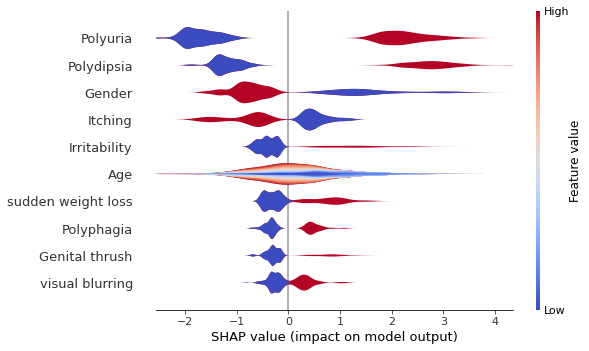

In [16]:
shap.summary_plot(shap_values, X_train, max_display=10, plot_type='layered_violin')

In [17]:
shap.force_plot(explainer.expected_value, shap_values, X_train)